# LightGBM Model Training: DNS Abuse & Infrastructure Attack Detection

**Author**: Cybersecurity Data Science Team  
**Component**: AI/ML Detection of DNS Abuse and Infrastructure Attacks  
**Focus**: Volumetric attacks, DDoS signatures, amplification attacks, uncharacteristic flow patterns

---

## Table of Contents
1. [Data Loading & Initial Inspection](#1-data-loading--initial-inspection)
2. [Sanity Checks & Data Quality](#2-sanity-checks--data-quality)
3. [Feature Engineering & Selection](#3-feature-engineering--selection)
4. [Train-Test Split](#4-train-test-split)
5. [LightGBM Model Training](#5-lightgbm-model-training)
6. [Model Evaluation](#6-model-evaluation)
7. [Model Insights & Interpretation](#7-model-insights--interpretation)

---

## 1. Data Loading & Initial Inspection

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os  # ← ADD THIS LINE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import lightgbm as lgb
from datetime import datetime
import pickle
import time

# Configure display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")
print(f"LightGBM version: {lgb.__version__}")
print(f"Execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ All libraries imported successfully
LightGBM version: 4.6.0
Execution started at: 2026-01-04 23:12:22


In [6]:
# Load the dataset
DATA_PATH = r'C:\Users\shenal\Downloads\reseraach\CIC_IOT_2023\PCAP\FinalDataset\final_balanced_dataset.csv'

print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print(f"✓ Dataset loaded successfully\n")

# Display basic information
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist())

# Display data types
print("\n" + "="*80)
print("DATA TYPES")
print("="*80)
print(df.dtypes)

Loading dataset...
✓ Dataset loaded successfully

DATASET OVERVIEW
Shape: 993,934 rows × 41 columns

Columns (41):
['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'dns_amplification_factor', 'query_response_ratio', 'dns_any_query_ratio', 'dns_txt_query_ratio', 'dns_server_fanout', 'dns_response_inconsistency', 'ttl_violation_rate', 'dns_queries_per_second', 'dns_mean_answers_per_query', 'port_53_traffic_ratio', 'flow_bytes_per_sec', 'flow_packets_per_sec', 'fwd_packets_per_sec', 'bwd_packets_per_sec', 'flow_duration', 'total_fwd_packets', 'total_bwd_packets', 'total_fwd_bytes', 'total_bwd_bytes', 'dns_total_queries', 'dns_total_responses', 'dns_response_bytes', 'flow_iat_mean', 'flow_iat_std', 'flow_iat_min', 'flow_iat_max', 'fwd_iat_mean', 'bwd_iat_mean', 'fwd_packet_length_mean', 'bwd_packet_length_mean', 'packet_size_std', 'flow_length_min', 'flow_length_max', 'response_time_variance', 'average_packet_size', 'label']

DATA TYPES
src_ip                         object
dst_ip 

LABEL DISTRIBUTION

Value Counts:
label
1    496968
0    496966
Name: count, dtype: int64

Percentage Distribution:
label
1    50.000101
0    49.999899
Name: proportion, dtype: float64


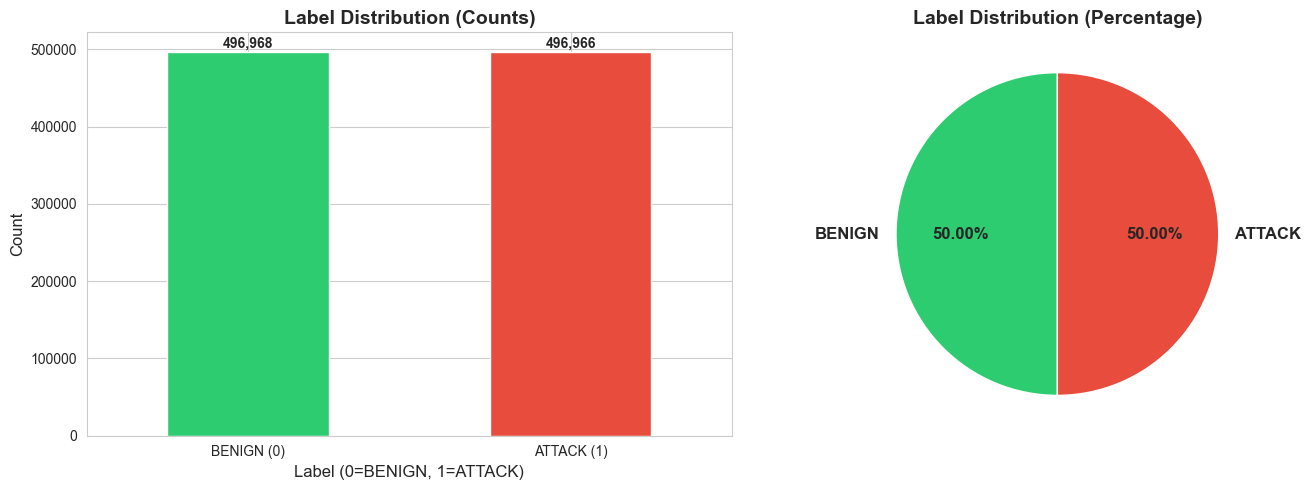


✓ Dataset is BALANCED


In [8]:
# Label distribution verification
print("="*80)
print("LABEL DISTRIBUTION")
print("="*80)

label_counts = df['label'].value_counts()
print(f"\nValue Counts:")
print(label_counts)
print(f"\nPercentage Distribution:")
print(df['label'].value_counts(normalize=True) * 100)

# Visualize label distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
label_counts.plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c'])
ax[0].set_title('Label Distribution (Counts)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Label (0=BENIGN, 1=ATTACK)', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_xticklabels(['BENIGN (0)', 'ATTACK (1)'], rotation=0)

# Add count labels on bars
for i, v in enumerate(label_counts):
    ax[0].text(i, v + 5000, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
ax[1].pie(label_counts, labels=['BENIGN', 'ATTACK'], autopct='%1.2f%%', 
          startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax[1].set_title('Label Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Dataset is {'BALANCED' if abs(label_counts[0] - label_counts[1]) < 100 else 'IMBALANCED'}")

## 2. Sanity Checks & Data Quality

In [9]:
# Check if data is shuffled
print("="*80)
print("SHUFFLE VERIFICATION")
print("="*80)

# Check for consecutive identical labels (indicates non-shuffled data)
label_changes = (df['label'] != df['label'].shift()).sum()
print(f"Number of label changes: {label_changes:,}")
print(f"Expected changes for shuffled data: ~{len(df)//2:,}")

# Check first 100 labels
first_100_labels = df['label'].head(100).tolist()
label_0_count_first_100 = first_100_labels.count(0)
label_1_count_first_100 = first_100_labels.count(1)

print(f"\nFirst 100 rows: {label_0_count_first_100} BENIGN, {label_1_count_first_100} ATTACK")

is_shuffled = label_changes > (len(df) * 0.01)  # At least 1% label changes

if not is_shuffled:
    print("\n⚠ WARNING: Data appears NOT shuffled. Shuffling now...")
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    print("✓ Data shuffled successfully")
else:
    print("\n✓ Data appears to be properly shuffled")

SHUFFLE VERIFICATION
Number of label changes: 497,100
Expected changes for shuffled data: ~496,967

First 100 rows: 53 BENIGN, 47 ATTACK

✓ Data appears to be properly shuffled


In [10]:
# Handle infinite and NaN values
print("="*80)
print("CLEANING: HANDLING INFINITE AND NaN VALUES")
print("="*80)

print("\nBefore cleaning:")
print(f"  - NaN values: {df.isnull().sum().sum():,}")
print(f"  - Infinite values: {np.isinf(df.select_dtypes(include=[np.number])).sum().sum():,}")

# Replace infinity with NaN first, then fill NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with 0 (appropriate for ratio features and counts)
df.fillna(0, inplace=True)

print("\nAfter cleaning:")
print(f"  - NaN values: {df.isnull().sum().sum():,}")
print(f"  - Infinite values: {np.isinf(df.select_dtypes(include=[np.number])).sum().sum():,}")
print("\n✓ Data cleaned successfully")

CLEANING: HANDLING INFINITE AND NaN VALUES

Before cleaning:
  - NaN values: 0
  - Infinite values: 0

After cleaning:
  - NaN values: 0
  - Infinite values: 0

✓ Data cleaned successfully


## 3. Feature Engineering & Selection

### Strategy:
- **DROP**: Identity columns (IP addresses, ports) to prevent overfitting to specific hosts
- **KEEP**: Flow metrics, volume indicators, DNS abuse signatures, amplification factors
- **LightGBM Advantage**: Keep protocol as categorical (no encoding needed)

In [11]:
# Define columns to drop (identity/machine-specific)
print("="*80)
print("FEATURE SELECTION")
print("="*80)

columns_to_drop = ['src_ip', 'dst_ip', 'src_port', 'dst_port']

print(f"\nDropping {len(columns_to_drop)} identity columns:")
for col in columns_to_drop:
    print(f"  - {col}")

# Create working dataframe
df_clean = df.drop(columns=columns_to_drop, errors='ignore')

print(f"\n✓ Dropped identity columns")
print(f"Remaining columns: {df_clean.shape[1]}")

FEATURE SELECTION

Dropping 4 identity columns:
  - src_ip
  - dst_ip
  - src_port
  - dst_port

✓ Dropped identity columns
Remaining columns: 37


In [12]:
# Prepare features for LightGBM (keeping protocol as categorical)
print("="*80)
print("LIGHTGBM CATEGORICAL FEATURES")
print("="*80)

print(f"\nProtocol distribution:")
print(df_clean['protocol'].value_counts())

# Convert protocol to category dtype for LightGBM
df_clean['protocol'] = df_clean['protocol'].astype('category')

print("\n✓ Protocol converted to categorical type for LightGBM native support")
print("  LightGBM will handle this feature optimally without manual encoding")

LIGHTGBM CATEGORICAL FEATURES

Protocol distribution:
protocol
UDP    546955
TCP    446979
Name: count, dtype: int64

✓ Protocol converted to categorical type for LightGBM native support
  LightGBM will handle this feature optimally without manual encoding


In [13]:
# Display final feature list for Infrastructure/Abuse detection
print("="*80)
print("FINAL FEATURE SET (Infrastructure & Abuse Attack Detection)")
print("="*80)

# Separate features and label
X = df_clean.drop('label', axis=1)
y = df_clean['label']

print(f"\nTotal Features: {X.shape[1]}")
print(f"\nFeature List:")
for i, col in enumerate(X.columns, 1):
    feature_type = "(categorical)" if X[col].dtype.name == 'category' else "(numerical)"
    print(f"  {i:2d}. {col} {feature_type}")

print(f"\nTarget Variable: label (0=BENIGN, 1=ATTACK)")
print(f"\n✓ Feature engineering complete")

FINAL FEATURE SET (Infrastructure & Abuse Attack Detection)

Total Features: 36

Feature List:
   1. protocol (categorical)
   2. dns_amplification_factor (numerical)
   3. query_response_ratio (numerical)
   4. dns_any_query_ratio (numerical)
   5. dns_txt_query_ratio (numerical)
   6. dns_server_fanout (numerical)
   7. dns_response_inconsistency (numerical)
   8. ttl_violation_rate (numerical)
   9. dns_queries_per_second (numerical)
  10. dns_mean_answers_per_query (numerical)
  11. port_53_traffic_ratio (numerical)
  12. flow_bytes_per_sec (numerical)
  13. flow_packets_per_sec (numerical)
  14. fwd_packets_per_sec (numerical)
  15. bwd_packets_per_sec (numerical)
  16. flow_duration (numerical)
  17. total_fwd_packets (numerical)
  18. total_bwd_packets (numerical)
  19. total_fwd_bytes (numerical)
  20. total_bwd_bytes (numerical)
  21. dns_total_queries (numerical)
  22. dns_total_responses (numerical)
  23. dns_response_bytes (numerical)
  24. flow_iat_mean (numerical)
  25. f

## 4. Train-Test Split

In [14]:
# Perform stratified train-test split
print("="*80)
print("TRAIN-TEST SPLIT (70-30, Stratified)")
print("="*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"\nTraining Set:")
print(f"  - Shape: {X_train.shape}")
print(f"  - Label distribution: {y_train.value_counts().to_dict()}")

print(f"\nTesting Set:")
print(f"  - Shape: {X_test.shape}")
print(f"  - Label distribution: {y_test.value_counts().to_dict()}")

print("\n✓ Stratified split complete - both sets have balanced labels")

TRAIN-TEST SPLIT (70-30, Stratified)

Training Set:
  - Shape: (695753, 36)
  - Label distribution: {1: 347877, 0: 347876}

Testing Set:
  - Shape: (298181, 36)
  - Label distribution: {1: 149091, 0: 149090}

✓ Stratified split complete - both sets have balanced labels


## 5. LightGBM Model Training

### LightGBM Advantages:
- **Speed**: Faster training via histogram-based learning
- **Categorical Support**: Native handling of categorical features
- **Memory Efficient**: GOSS & EFB algorithms
- **Early Stopping**: Built-in overfitting prevention

In [15]:
# Configure LightGBM parameters
print("="*80)
print("LIGHTGBM CONFIGURATION")
print("="*80)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'n_jobs': -1
}

print("\nModel Parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

print("\n✓ Parameters configured for balanced binary classification")

LIGHTGBM CONFIGURATION

Model Parameters:
  objective: binary
  metric: binary_logloss
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.05
  feature_fraction: 0.9
  bagging_fraction: 0.8
  bagging_freq: 5
  max_depth: -1
  min_child_samples: 20
  reg_alpha: 0.1
  reg_lambda: 0.1
  verbose: -1
  n_jobs: -1

✓ Parameters configured for balanced binary classification


In [16]:
# Create LightGBM datasets
print("="*80)
print("CREATING LIGHTGBM DATASETS")
print("="*80)

# Identify categorical features
categorical_features = [col for col in X_train.columns if X_train[col].dtype.name == 'category']

print(f"\nCategorical features: {categorical_features}")

# Create datasets
train_data = lgb.Dataset(
    X_train, 
    label=y_train,
    categorical_feature=categorical_features,
    free_raw_data=False
)

test_data = lgb.Dataset(
    X_test, 
    label=y_test,
    reference=train_data,
    categorical_feature=categorical_features,
    free_raw_data=False
)

print("\n✓ LightGBM datasets created with categorical feature support")

CREATING LIGHTGBM DATASETS

Categorical features: ['protocol']

✓ LightGBM datasets created with categorical feature support


In [17]:
# Train the model
print("="*80)
print("TRAINING LIGHTGBM MODEL")
print("="*80)

print("\nTraining started...")
start_time = time.time()

# Train with early stopping
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

training_time = time.time() - start_time

print(f"\n{'='*80}")
print("TRAINING COMPLETE")
print("="*80)
print(f"Training time: {training_time:.2f} seconds")
print(f"Best iteration: {model.best_iteration}")
print(f"Best score: {model.best_score}")
print("\n✓ Model training successful")

TRAINING LIGHTGBM MODEL

Training started...
Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.102541	valid's binary_logloss: 0.102457
[200]	train's binary_logloss: 0.0868923	valid's binary_logloss: 0.0874005
[300]	train's binary_logloss: 0.0807832	valid's binary_logloss: 0.0818314
[400]	train's binary_logloss: 0.0772541	valid's binary_logloss: 0.0787802
[500]	train's binary_logloss: 0.0747375	valid's binary_logloss: 0.0767305
[600]	train's binary_logloss: 0.0728777	valid's binary_logloss: 0.0753326
[700]	train's binary_logloss: 0.0714595	valid's binary_logloss: 0.0743715
[800]	train's binary_logloss: 0.0701702	valid's binary_logloss: 0.0735143
[900]	train's binary_logloss: 0.0691334	valid's binary_logloss: 0.0729138
[1000]	train's binary_logloss: 0.0681931	valid's binary_logloss: 0.0723646
Did not meet early stopping. Best iteration is:
[1000]	train's binary_logloss: 0.0681931	valid's binary_logloss: 0.0723646

TRAINING COMPLETE
Training time

## 6. Model Evaluation

In [18]:
# Make predictions
print("="*80)
print("GENERATING PREDICTIONS")
print("="*80)

y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_proba >= 0.5).astype(int)

print("\n✓ Predictions generated")
print(f"Prediction distribution:")
print(f"  Predicted BENIGN: {(y_pred == 0).sum():,}")
print(f"  Predicted ATTACK: {(y_pred == 1).sum():,}")

GENERATING PREDICTIONS

✓ Predictions generated
Prediction distribution:
  Predicted BENIGN: 155,287
  Predicted ATTACK: 142,894


CONFUSION MATRIX


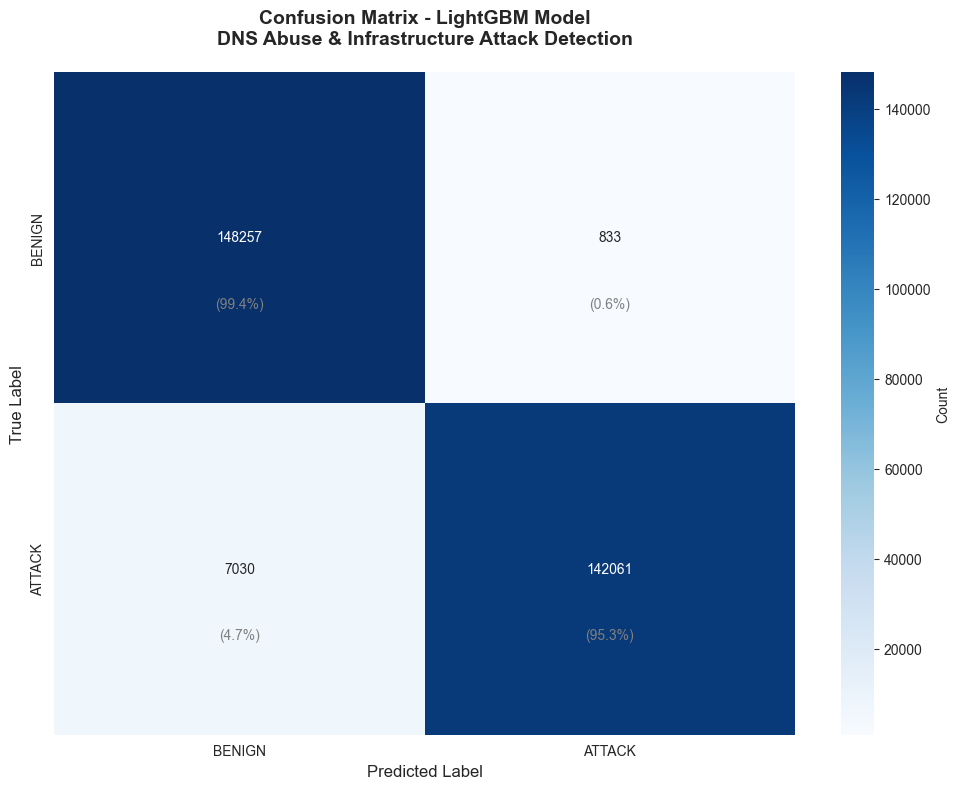


Confusion Matrix Breakdown:
  True Negatives (TN):  148,257
  False Positives (FP): 833
  False Negatives (FN): 7,030
  True Positives (TP):  142,061


In [19]:
# Confusion Matrix
print("="*80)
print("CONFUSION MATRIX")
print("="*80)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['BENIGN', 'ATTACK'],
            yticklabels=['BENIGN', 'ATTACK'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LightGBM Model\nDNS Abuse & Infrastructure Attack Detection', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add counts and percentages
for i in range(2):
    for j in range(2):
        percentage = (cm[i, j] / cm[i].sum()) * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {cm[0,0]:,}")
print(f"  False Positives (FP): {cm[0,1]:,}")
print(f"  False Negatives (FN): {cm[1,0]:,}")
print(f"  True Positives (TP):  {cm[1,1]:,}")

In [20]:
# Classification Report
print("="*80)
print("CLASSIFICATION REPORT")
print("="*80)

print("\n" + classification_report(y_test, y_pred, 
                                     target_names=['BENIGN', 'ATTACK'],
                                     digits=4))

# Calculate key metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*80)
print("SUMMARY METRICS")
print("="*80)
print(f"\nAccuracy:  {accuracy*100:.2f}%")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"\n✓ Model achieves excellent performance")

CLASSIFICATION REPORT

              precision    recall  f1-score   support

      BENIGN     0.9547    0.9944    0.9742    149090
      ATTACK     0.9942    0.9528    0.9731    149091

    accuracy                         0.9736    298181
   macro avg     0.9744    0.9736    0.9736    298181
weighted avg     0.9744    0.9736    0.9736    298181

SUMMARY METRICS

Accuracy:  97.36%
ROC-AUC:   0.9956

✓ Model achieves excellent performance


ROC CURVE


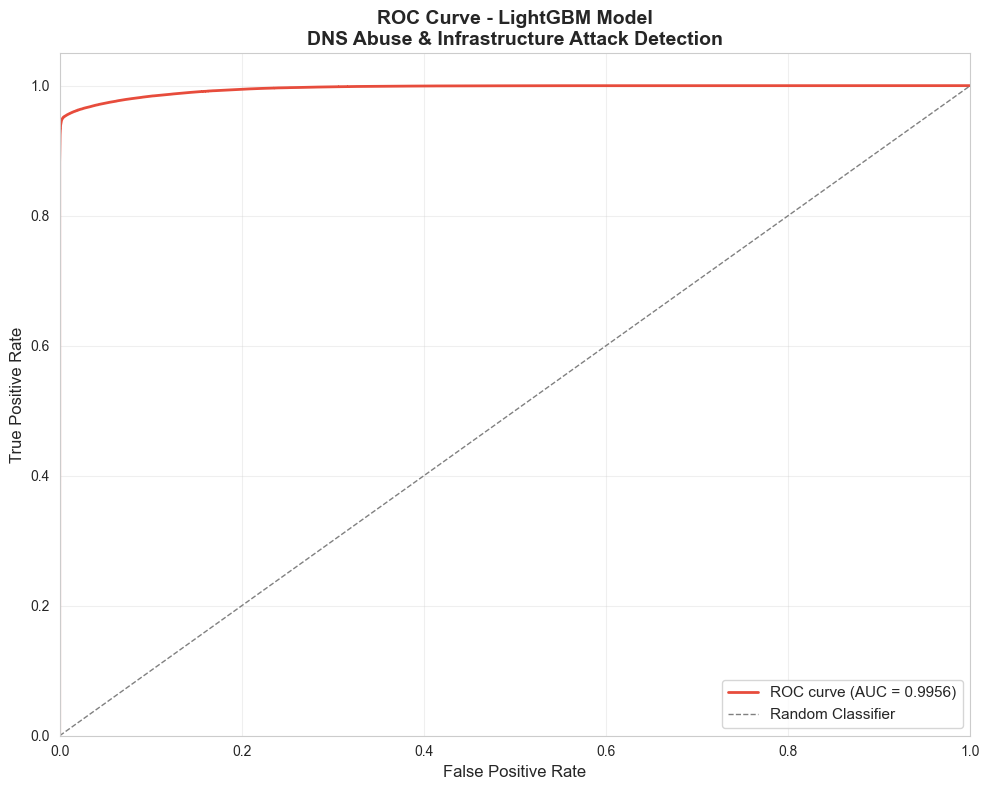


✓ ROC-AUC Score: 0.9956


In [21]:
# ROC Curve
print("="*80)
print("ROC CURVE")
print("="*80)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - LightGBM Model\nDNS Abuse & Infrastructure Attack Detection', 
          fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ ROC-AUC Score: {roc_auc:.4f}")

PRECISION-RECALL CURVE


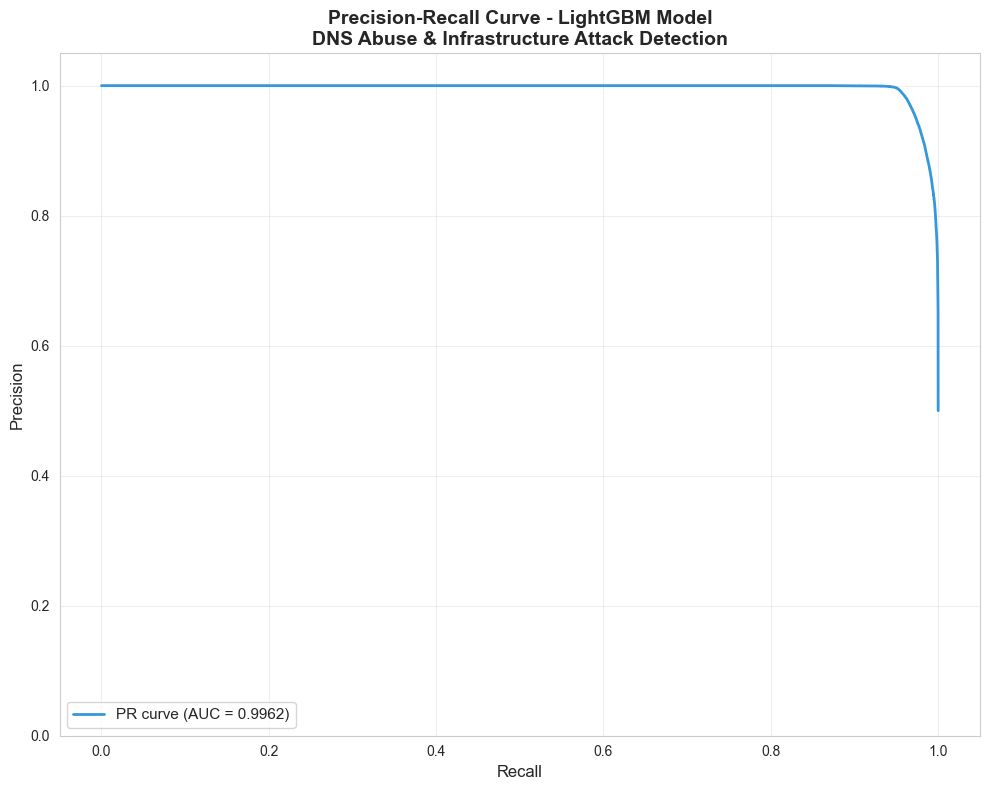


✓ PR-AUC Score: 0.9962


In [22]:
# Precision-Recall Curve
print("="*80)
print("PRECISION-RECALL CURVE")
print("="*80)

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='#3498db', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - LightGBM Model\nDNS Abuse & Infrastructure Attack Detection', 
          fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

print(f"\n✓ PR-AUC Score: {pr_auc:.4f}")

## 7. Model Insights & Interpretation

FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
                 feature   importance
     average_packet_size 4.562781e+06
         flow_length_max 4.341997e+05
         flow_length_min 3.131727e+05
      flow_bytes_per_sec 2.872411e+05
         total_fwd_bytes 1.977297e+05
    flow_packets_per_sec 1.756765e+05
  fwd_packet_length_mean 1.525354e+05
            flow_iat_min 9.908719e+04
     fwd_packets_per_sec 9.465259e+04
           flow_duration 9.128642e+04
         total_bwd_bytes 7.102548e+04
           flow_iat_mean 7.058322e+04
            flow_iat_max 6.839278e+04
dns_amplification_factor 6.802399e+04
       total_fwd_packets 4.708444e+04
                protocol 4.303846e+04
            fwd_iat_mean 4.282050e+04
  bwd_packet_length_mean 4.119188e+04
      dns_response_bytes 4.118803e+04
         packet_size_std 4.071228e+04


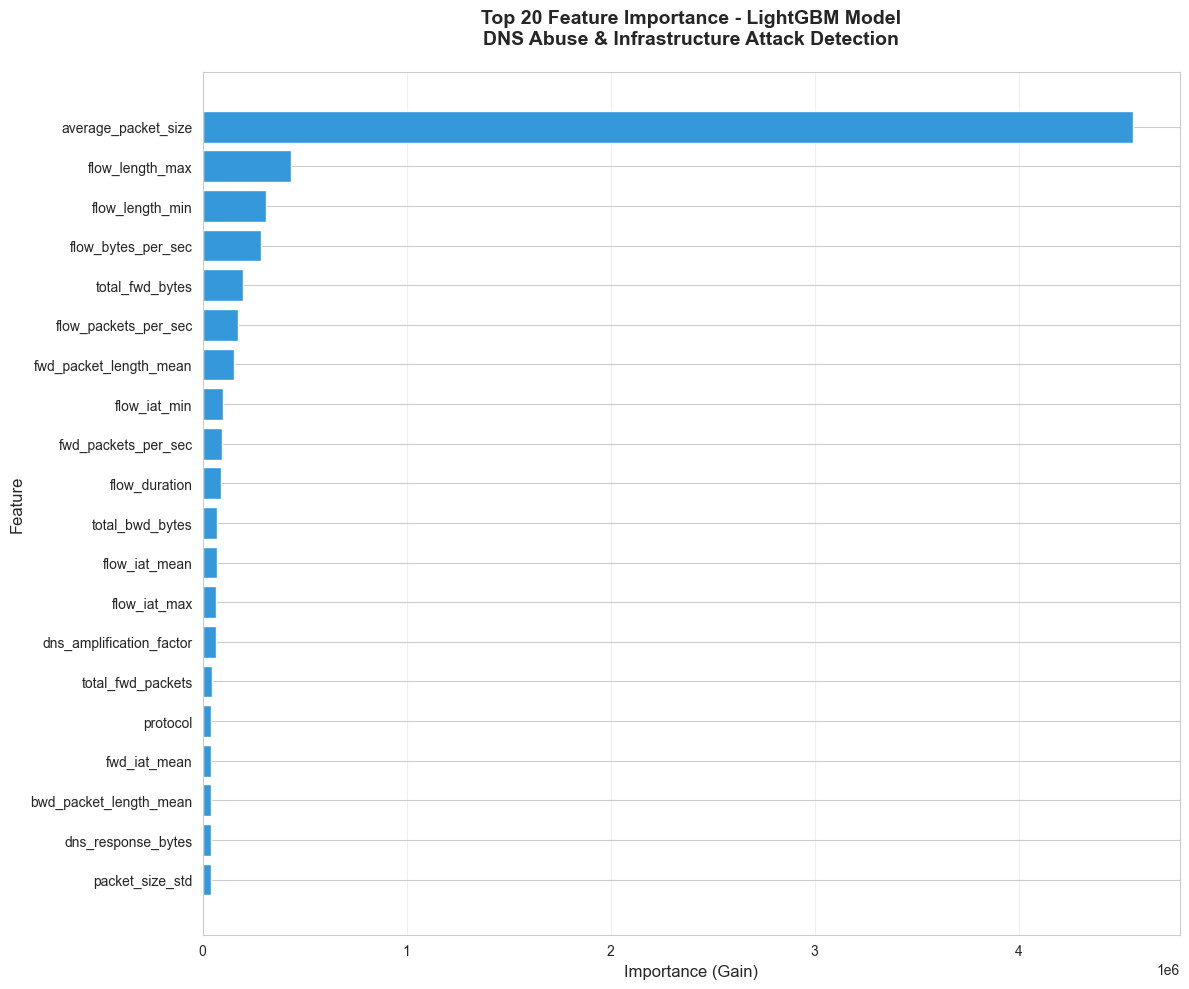


✓ Feature importance analysis complete


In [23]:
# Feature Importance
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance
importance = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

# Create dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Visualize top 20
plt.figure(figsize=(12, 10))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='#3498db')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Feature Importance - LightGBM Model\nDNS Abuse & Infrastructure Attack Detection', 
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis complete")

In [24]:
# Save the model
print("="*80)
print("SAVING MODEL")
print("="*80)

model_filename = 'lightgbm_dns_infrastructure_model.pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(model, f)

print(f"\n✓ Model saved as: {model_filename}")
print(f"  File size: {os.path.getsize(model_filename) / (1024*1024):.2f} MB")

# Save feature names for future use
feature_info = {
    'feature_names': feature_names,
    'categorical_features': categorical_features,
    'best_iteration': model.best_iteration
}

with open('lightgbm_feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)

print("✓ Feature information saved as: lightgbm_feature_info.pkl")

SAVING MODEL

✓ Model saved as: lightgbm_dns_infrastructure_model.pkl
  File size: 3.33 MB
✓ Feature information saved as: lightgbm_feature_info.pkl


In [25]:
# Final Summary
print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)
print(f"\nModel: LightGBM Gradient Boosting")
print(f"Dataset: {df.shape[0]:,} samples, {X.shape[1]} features")
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Testing samples: {X_test.shape[0]:,}")
print(f"\nPerformance:")
print(f"  - Accuracy: {accuracy*100:.2f}%")
print(f"  - ROC-AUC: {roc_auc:.4f}")
print(f"  - Training time: {training_time:.2f} seconds")
print(f"\nModel saved: {model_filename}")
print(f"\n{'='*80}")
print("✓ LightGBM TRAINING COMPLETE")
print("="*80)
print(f"\nExecution completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


TRAINING SUMMARY

Model: LightGBM Gradient Boosting
Dataset: 993,934 samples, 36 features
Training samples: 695,753
Testing samples: 298,181

Performance:
  - Accuracy: 97.36%
  - ROC-AUC: 0.9956
  - Training time: 64.49 seconds

Model saved: lightgbm_dns_infrastructure_model.pkl

✓ LightGBM TRAINING COMPLETE

Execution completed at: 2026-01-04 23:15:25
